In [63]:
import numpy as np
import scipy.io
import os
import h5py
import sensors
import importlib

<module 'sensors' from '/Users/stepanmazokha/Desktop/mobintel-rffi/matlab/pkl_creation/sensors.py'>

In [73]:
MIN_FRAMES = 400
FRAMES_TRAIN = 400
FRAMES_TEST = 100
PKT_LEN = 400

ROOT_DIR_FRAMES = '/Users/stepanmazokha/Desktop/orbit_dataset_1rx/orbit_frames_rffi_dataset'
NODE_DIR = '/training_2024-07-13_06-53-20'

# NODE_DIR = '/epoch_2024-07-13_07-40-21'
# NODE_DIR = '/epoch_2024-07-13_07-52-31'
# NODE_DIR = '/epoch_2024-07-13_08-03-18'
# NODE_DIR = '/epoch_2024-07-13_08-14-13'
# NODE_DIR = '/epoch_2024-07-13_08-27-13'
# NODE_DIR = '/epoch_2024-07-13_08-38-59'
# NODE_DIR = '/epoch_2024-07-13_08-51-04'
# NODE_DIR = '/epoch_2024-07-13_09-02-07'
# NODE_DIR = '/epoch_2024-07-13_09-17-04'
# NODE_DIR = '/epoch_2024-07-13_09-31-48'

DIR_SOURCE = ROOT_DIR_FRAMES + NODE_DIR + '/equalized_packets/'
FILE_TARGET_NON_EQ_TRAIN = ROOT_DIR_FRAMES + NODE_DIR +'/node1-1_non_eq_train.h5'
FILE_TARGET_EQ_TRAIN = ROOT_DIR_FRAMES + NODE_DIR + '/node1-1_eq_train.h5'
FILE_TARGET_NON_EQ_TEST = ROOT_DIR_FRAMES + NODE_DIR + '/node1-1_non_eq_test.h5'
FILE_TARGET_EQ_TEST = ROOT_DIR_FRAMES + NODE_DIR + '/node1-1_eq_test.h5'
ORBIT_DEVICE_INFO = ROOT_DIR_FRAMES + '/orbit_device_info.json'

In [88]:
importlib.reload(sensors)

# Retrieve node info from Orbit API OR load a file
# get_orbit_node_infos(ALL_NODE_DICT, file_path=ORBIT_DEVICE_INFO)
node_infos_all = sensors.read_json_file_to_dict(file_path=ORBIT_DEVICE_INFO)

# Filter available nodes by availability of a particular WiFi chipset
node_list_filtered = sensors.filter_nodes_by_wifi_chip(node_infos=node_infos_all, chip_models=['5212'])

# Filter remaining nodes by their availability in a given directory
node_list_filtered = sensors.filter_nodes_by_dir_presence(node_list_filtered, dir_path=DIR_SOURCE)

In [90]:
importlib.reload(sensors)

# Filter available nodes by availability of a particular type & model of a USRP
node_list_usrp = sensors.filter_nodes_by_usrp_model(node_infos=node_infos_all, usrp_types=['USRP2'], usrp_models=['N210r4'], verbose=True)

node_list_usrp

[ FFFE:0004 ]: 1-1 : node1-1.grid.orbit-lab.org_dev_7 ( USRP2 / N-Series Device  |  N210r4 )
[ FFFE:0004 ]: 1-2 : node1-2.grid.orbit-lab.org_dev_6 ( USRP2 / N-Series Device  |  N210r4 )
[ FFFE:0004 ]: 1-19 : node1-19.grid.orbit-lab.org_dev_5 ( USRP2 / N-Series Device  |  N210r4 )
[ FFFE:0004 ]: 1-20 : node1-20.grid.orbit-lab.org_dev_6 ( USRP2 / N-Series Device  |  N210r4 )
[ FFFE:0004 ]: 2-1 : node2-1.grid.orbit-lab.org_dev_6 ( USRP2 / N-Series Device  |  N210r4 )
[ FFFE:0004 ]: 2-2 : node2-2.grid.orbit-lab.org_dev_6 ( USRP2 / N-Series Device  |  N210r4 )
[ FFFE:0004 ]: 2-19 : node2-19.grid.orbit-lab.org_dev_5 ( USRP2 / N-Series Device  |  N210r4 )
[ FFFE:0004 ]: 2-20 : node2-20.grid.orbit-lab.org_dev_6 ( USRP2 / N-Series Device  |  N210r4 )
[ FFFE:0004 ]: 7-7 : node7-7.grid.orbit-lab.org_dev_5 ( USRP2 / N-Series Device  |  N210r4 )
[ FFFE:0004 ]: 7-14 : node7-14.grid.orbit-lab.org_dev_6 ( USRP2 / N-Series Device  |  N210r4 )
[ FFFE:0004 ]: 8-8 : node8-8.grid.orbit-lab.org_dev_6 ( USRP

['1-1',
 '1-2',
 '1-19',
 '1-20',
 '2-1',
 '2-2',
 '2-19',
 '2-20',
 '7-7',
 '7-14',
 '8-8',
 '8-13',
 '11-10',
 '13-8',
 '13-13',
 '14-7',
 '14-14',
 '19-1',
 '19-2',
 '19-19',
 '19-20',
 '20-1',
 '20-2',
 '20-19',
 '20-20']

In [43]:
def save_dataset_h5(file_target, label, data):
    print('Saving', file_target)
    with h5py.File(file_target, 'w') as h5file:
        h5file.create_dataset('label', data=label, dtype='float64')
        h5file.create_dataset('data', data=data, dtype='float64')        

def package_dataset_h5(node_names, dir_source, frame_count, sample_count, id_filter):
    if id_filter:
        L = len(id_filter)
    else: L = len(node_names)

    h5data_non_eq = np.zeros((L * frame_count, sample_count * 2), dtype='float64')
    h5data_eq = np.zeros((L * frame_count, sample_count * 2), dtype='float64')
    h5labels = np.zeros((L * frame_count, 1), dtype='float64')

    print(h5labels.shape)

    h5_idx = 0
    for node_idx in np.arange(len(node_names)):
        node_name = node_names[node_idx]
        node_id = ALL_NODE_DICT[node_name]

        if id_filter and node_id not in id_filter:
            print("Node", node_name, "isn't in the allowed set of devices.")
            continue

        print("Processing", node_name)

        f = scipy.io.loadmat(dir_source + 'packets_node' + node_name, verify_compressed_data_integrity=False)
        
        # Retrieve the list of frames; each item is a cell, containing two vectors: non-eq & eq IQ samples
        frames = f['packet_log'][0]

        if len(frames) < frame_count:
            print('Not enough frames for ', node_name)
            continue

        for frame_idx in np.arange(frame_count):
            iq_non_eq = frames[frame_idx][0:frame_count, 0] # non-equalized
            iq_eq = frames[frame_idx][0:frame_count, 1] # equalized

            h5data_non_eq[h5_idx, 0::2] = np.real(iq_non_eq)
            h5data_non_eq[h5_idx, 1::2] = np.imag(iq_non_eq)

            h5data_eq[h5_idx, 0::2] = np.real(iq_eq)
            h5data_eq[h5_idx, 1::2] = np.imag(iq_eq)

            h5labels[h5_idx] = ALL_NODE_DICT[node_name]
            
            h5_idx = h5_idx + 1

    return [h5data_non_eq, h5data_eq, h5labels]

def process_save_rx(node_list_filtered, dir_source, frame_count, sample_count, file_target_non_eq_train, file_target_eq_train, file_target_non_eq_class, file_target_eq_class):
    # nodes_train = node_list_filtered[0:30] # use first 30 devices for training the model
    # nodes_class = node_list_filtered[30:] # use second 30 devices for testing the model

    nodes_train = ['5-1', '7-10', '7-14', '2-19', '5-5', '19-1', '20-20',
        '1-10', '8-20', '11-17', '2-6', '1-12', '4-1', '3-13', '1-16', '8-8', '8-18', '1-19',
        '1-18', '11-7', '20-12', '4-10', '11-4', '8-3', '4-11', '3-18', '14-7', '10-17', '10-11']
    nodes_class = ['12-20', '17-11', '20-19', '20-1', '20-15', '14-10', '16-16', '15-1', '14-7', '16-1']

    # class_unit_ids = [391, 360, 329, 266, 330, 300, 269, 394, 239, 398, 242, 280, 378, 315, 380]

    # [h5data_non_eq_train, h5data_eq_train, h5labels_train] = package_dataset_h5(nodes_train, dir_source, frame_count, sample_count, None)
    [h5data_non_eq_class, h5data_eq_class, h5labels_class] = package_dataset_h5(nodes_class, dir_source, frame_count, sample_count, None)

    # Save to H5
    # save_dataset_h5(file_target=file_target_non_eq_train, label=h5labels_train, data=h5data_non_eq_train)
    # save_dataset_h5(file_target=file_target_eq_train, label=h5labels_train, data=h5data_eq_train)

    save_dataset_h5(file_target=file_target_non_eq_class, label=h5labels_class, data=h5data_non_eq_class)
    save_dataset_h5(file_target=file_target_eq_class, label=h5labels_class, data=h5data_eq_class)

process_save_rx(node_list_filtered, DIR_SOURCE, MIN_FRAMES, PKT_LEN, FILE_TARGET_NON_EQ_TRAIN, FILE_TARGET_EQ_TRAIN, FILE_TARGET_NON_EQ_TEST, FILE_TARGET_EQ_TEST)

(4000, 1)
Processing 12-20
Processing 17-11
Processing 20-19
Processing 20-1
Processing 20-15
Processing 14-10
Processing 16-16
Processing 15-1
Processing 14-7
Processing 16-1
Saving /Users/stepanmazokha/Desktop/orbit_frames_rffi_dataset/epoch_2024-07-13_09-31-48/node1-1_non_eq_test.h5
Saving /Users/stepanmazokha/Desktop/orbit_frames_rffi_dataset/epoch_2024-07-13_09-31-48/node1-1_eq_test.h5


In [60]:
def read_dataset_h5(file_target, dataset_name):
    with h5py.File(file_target, 'r') as h5file:
        dataset = h5file[dataset_name][:]
    return dataset

a = read_dataset_h5(FILE_TARGET_EQ_TRAIN, 'label')

len(set(a.flatten()))

29

In [73]:
def image_size_calc(L, N):
    # In STFT, with 50% overlap, we've got the following formula to determine size of the image:
    # L = N + (N/2) * (M-1), where:
    # - L: # of samples in the preamble (Shen had 8192)
    # - N: nfft (Shen had it as 256)
    # - M: # of windows
    # Therefore, to estimate M we'll have the formula: 
    # M = 1 + (2/N) * (L - N)
    return int(1 + (2/N) * (L - N))

image_size_calc(8192, 256)

63

In [55]:
def get_node_names_file(path1):
    with h5py.File(path1, 'r') as h5file1:
        label = h5file1['label'][:]

    items = ["" for x in range(len(ALL_NODE_DICT.keys()))]

    for key in ALL_NODE_DICT.keys():
        value = ALL_NODE_DICT[key]
        items[value] = key

    unique = list(set(label.flatten()))


    node_names = []

    for l in unique:
        node_names.append(str(items[int(l)]))

    return node_names

train_names = get_node_names_file('/Users/stepanmazokha/Desktop/wisig_frames_rffi_dataset/node1-1_wifi_2021_03_01/node1-1_eq_train.h5')
test_names = get_node_names_file('/Users/stepanmazokha/Desktop/wisig_frames_rffi_dataset/node1-1_wifi_2021_03_01/node1-1_eq_test.h5')


node_infos[train_names[0]]


[{'@INV_dev_id': '8086:1502',
  '@INV_dev_type': '82579LM Gigabit Network Connection [8086:1502]',
  '@INV_if_mac': '00:03:1d:0c:7d:d0',
  '@INV_if_name': 'eth0',
  '@name': 'node7-10.grid.orbit-lab.org_dev_0',
  '@status': 'OK',
  '@type': 'device'},
 {'@INV_dev_id': '8086:10D3',
  '@INV_dev_type': '82574L Gigabit Network Connection [8086:10D3]',
  '@INV_if_mac': '00:03:1d:0c:7d:d1',
  '@INV_if_name': 'eth1',
  '@name': 'node7-10.grid.orbit-lab.org_dev_1',
  '@status': 'OK',
  '@type': 'device'},
 {'@INV_dev_id': '168C:002A',
  '@INV_dev_type': 'AR928X Wireless Network Adapter (PCI-Express) [168C:2A]',
  '@INV_if_mac': 'N/A',
  '@INV_if_name': 'N/A',
  '@name': 'node7-10.grid.orbit-lab.org_dev_2',
  '@status': 'OK',
  '@type': 'device'},
 {'@INV_dev_id': '168C:0013',
  '@INV_dev_type': 'AR5212/5213/2414 Wireless Network Adapter [168C:13]',
  '@INV_if_mac': 'N/A',
  '@INV_if_name': 'N/A',
  '@name': 'node7-10.grid.orbit-lab.org_dev_3',
  '@status': 'OK',
  '@type': 'device'},
 {'@INV_d

In [102]:
path1 = '/Users/stepanmazokha/Desktop/wisig_frames_rffi_dataset/node1-1_wifi_2021_03_01/node1-1_eq_test.h5'
path2 = '/Users/stepanmazokha/Desktop/wisig_frames_rffi_dataset/node1-1_wifi_2021_03_08/node1-1_eq_test.h5'

label1 = []
label2 = []
with h5py.File(path1, 'r') as h5file1:
    label1 = h5file1['label'][:]

with h5py.File(path2, 'r') as h5file2:
    label2 = h5file2['label'][:]

l1 = set(label1.flatten())
l2 = set(label2.flatten())

common_test_units = l1.intersection(l2)

print(common_test_units)

# for unit in common_test_units:
    # print(int(unit))

{391.0, 360.0, 329.0, 266.0, 330.0, 300.0, 269.0, 394.0, 239.0, 398.0, 242.0, 280.0, 378.0, 315.0, 380.0}


In [103]:
for i in l1:
    print(i)

391.0
360.0
329.0
266.0
330.0
300.0
269.0
394.0
239.0
398.0
242.0
280.0
378.0
315.0
380.0


<Axes: >

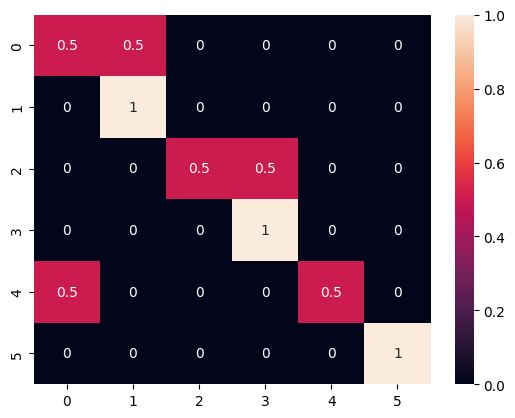

In [111]:
from sklearn.metrics import confusion_matrix
import seaborn as sea

val_true = [1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6]
val_pred = [2, 1, 2, 2, 4, 3, 4, 4, 5, 1, 6, 6]

matrix = confusion_matrix(val_true, val_pred, normalize='true')

sea.heatmap(matrix, annot=True)